<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter10SamplingStrategy/CACTITomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Simple CACTI coding example
##David Brady
##University of Arizona
##November 2023


Here we consider coding strategies for reconstruction of a signal of one spatial dimension and time $f(x,t)$. We assume a vector of 1D measurements taken in a snapshot
$$
g(x)=\int f(x,t)h(x,t) dt
$$
Examples include stroboscopic imaging, which which case $h(t)$ is a sequence of pulses and moving coded aperture imaging, in which case $h(x)$ is a random code and
$$
g(x)=\int f(x,t)h(x-vt) dt
$$
and random coded illumination, in which case $h(x,t)$ is a random sequence of spatial codes.

We use the estimation strategy developed for tomographic imaging in Section 4.4 of **Computational Imaging**

### Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist


## Forward Models

As in chapter 4, we seek to reconstruct the MNIST data set from compressive measurements. The MIST images are 28 by 28 pixels. In the present case, we seek to reconstruct from a single vector of 28 measurements integrated along the horizontal axis. We use random binary codes for our measurement matrices. For the first instance the code is a 28 element random sequence and
$$
h_{ij}=p[j]
$$
This corresponds to strobing the planes of the data cube. In the second case,
$$
h_{ij}=p[i-j]
$$
This corresponds to shifting the code diagonally across the measurement plane.
In the final case $h_{ij}$ is itself a random binary value.
Measurements take the form
$$
g_i=\sum_j h_{ij}f_{ij}
$$


### example sampling matrices

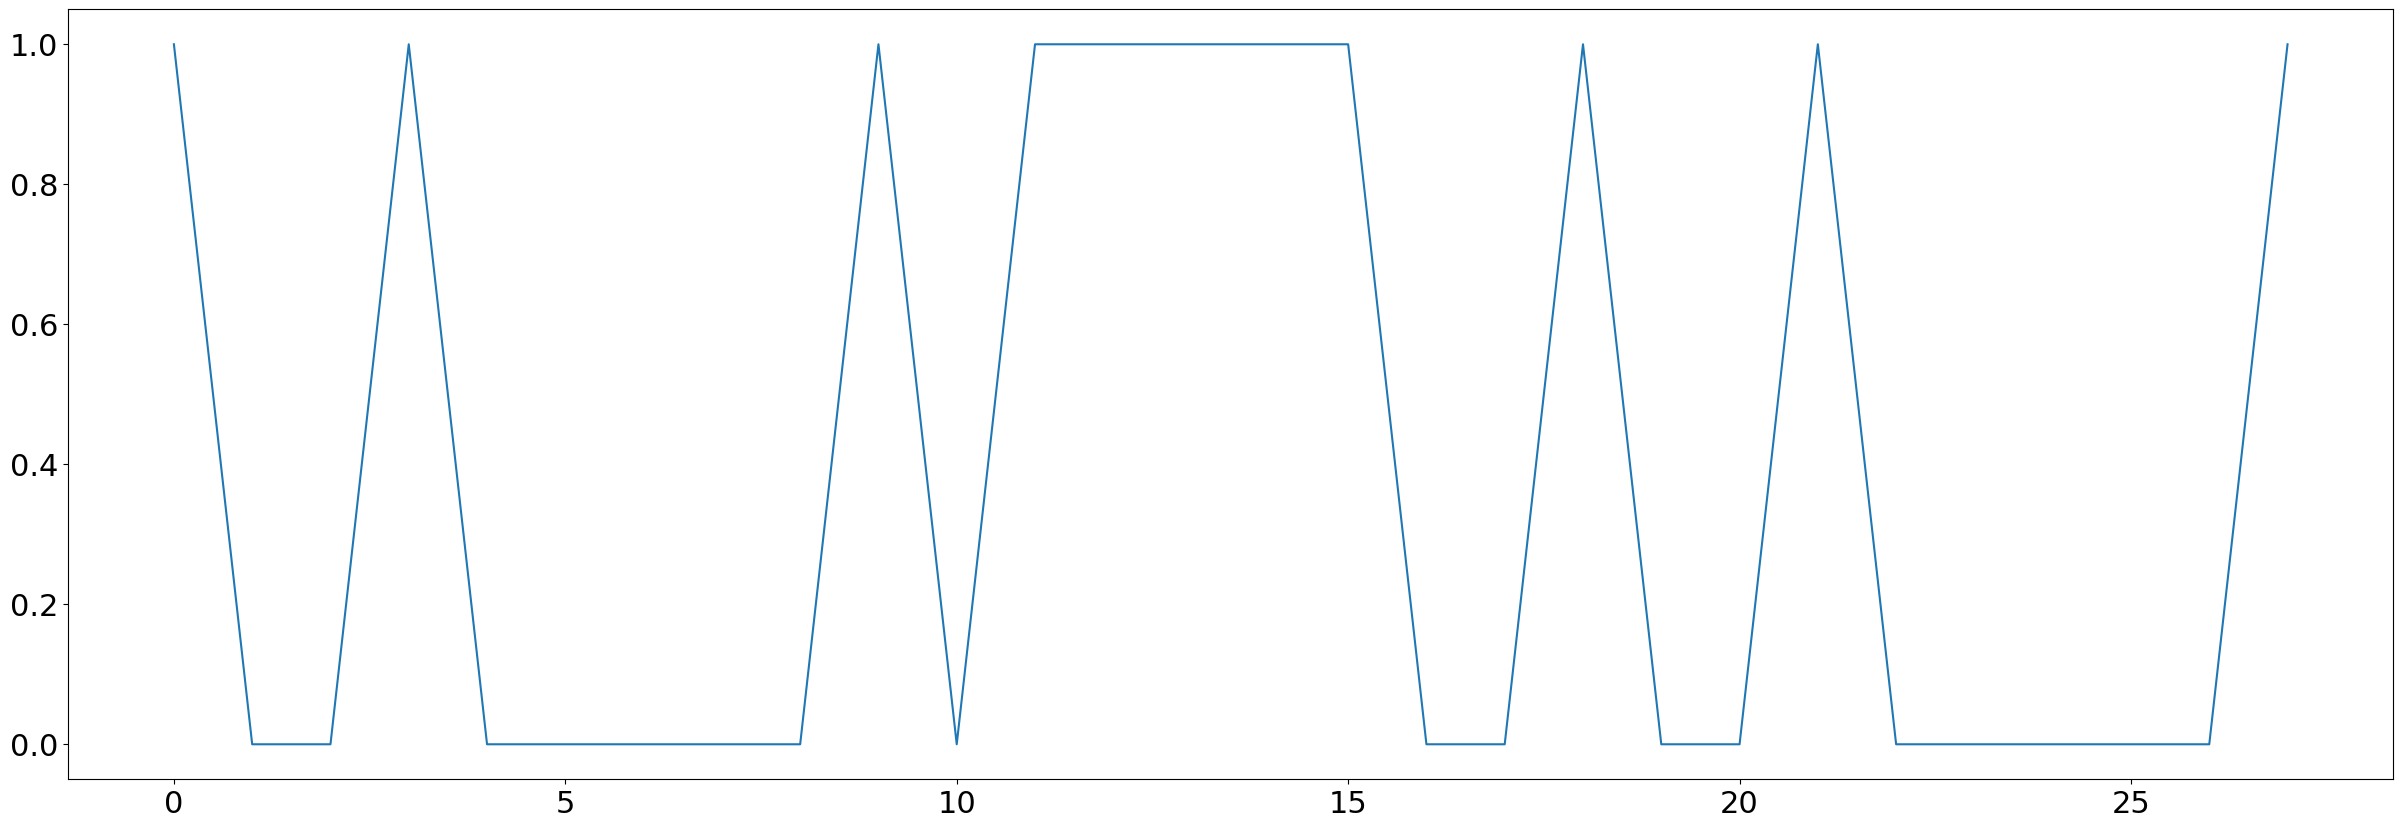

In [3]:
N=28
p=np.random.randint(0,2,28)
plt.plot(p)

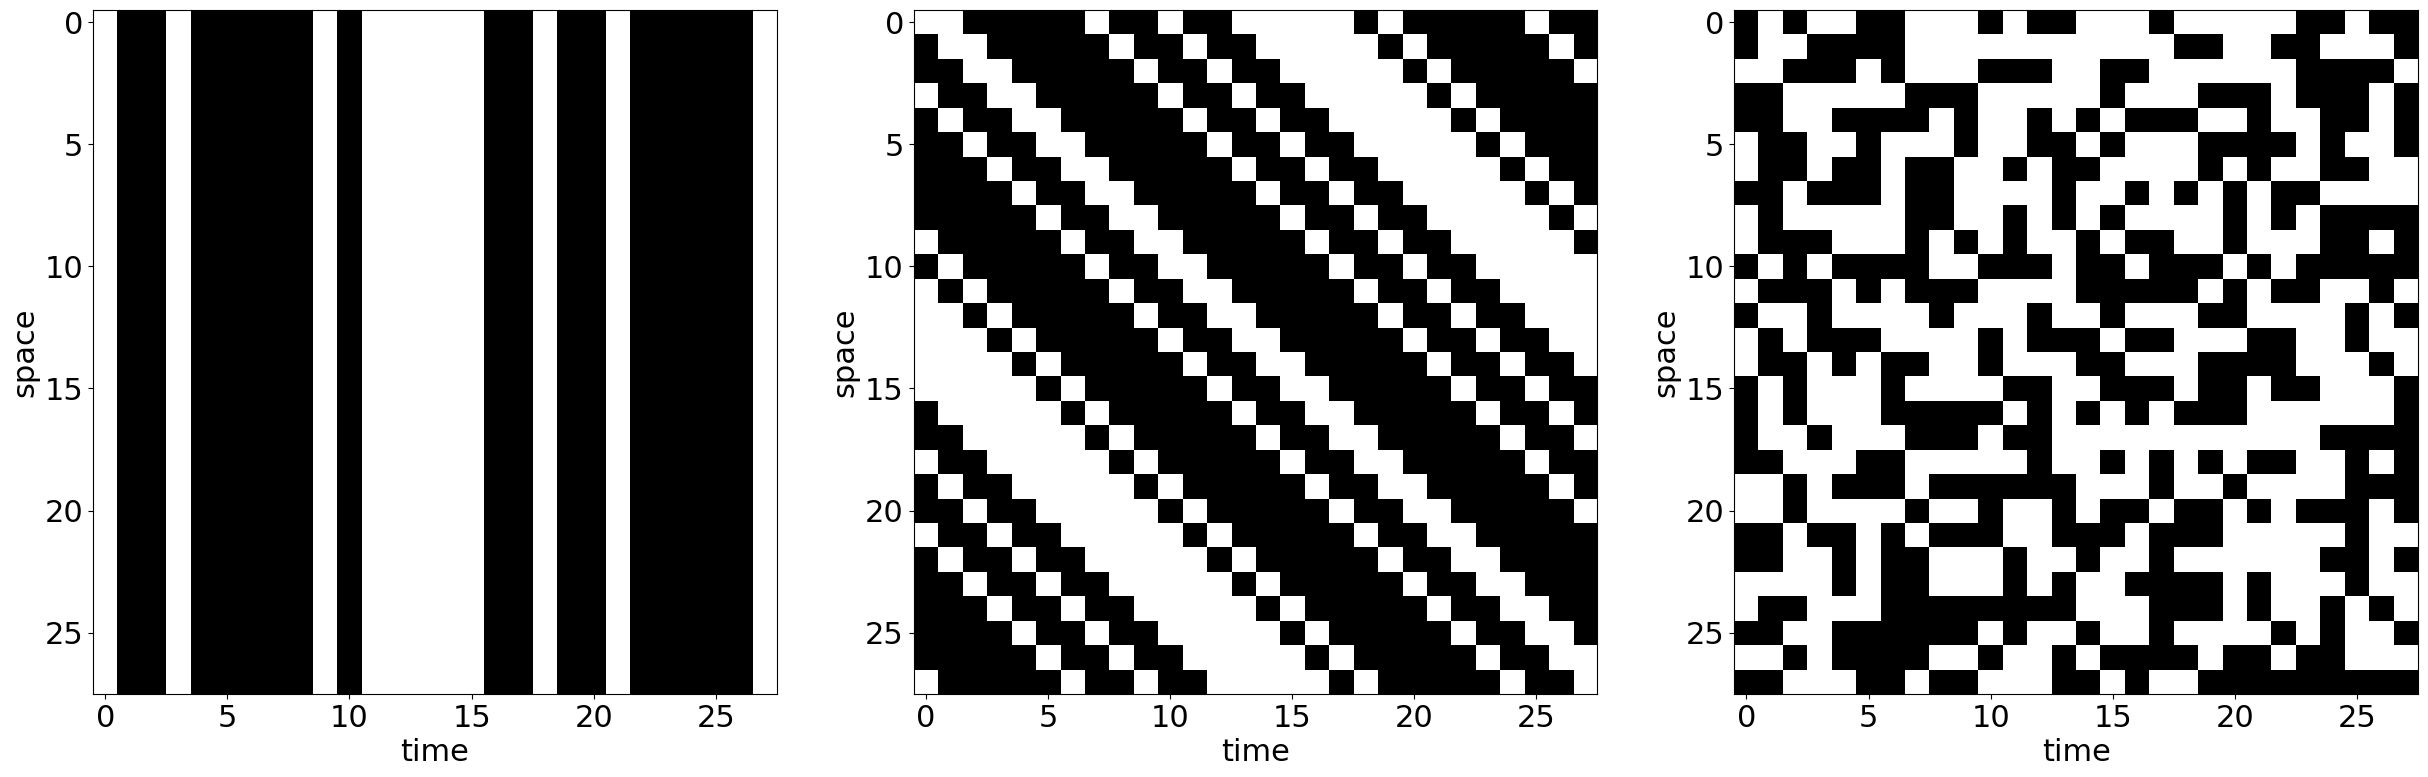

In [4]:
h1=np.zeros((N,N))
h2=np.zeros((N,N))
h3=np.random.randint(0,2,(N,N))
H1=np.zeros((N,N**2))
H2=np.zeros((N,N**2))
H3=np.zeros((N,N**2))
for pop in range(N):
  h1[:,pop]=p[pop]
  h2[:,pop]=np.roll(p,pop)
  H1[pop,(pop*N):((pop+1)*N)]=h1[:,pop]
  H2[pop,(pop*N):((pop+1)*N)]=h2[:,pop]
  H3[pop,(pop*N):((pop+1)*N)]=h3[:,pop]
plt.subplot(1,3,1)
plt.imshow(h1, cmap='gray')
plt.xlabel('time')
plt.ylabel('space')
plt.subplot(1,3,2)
plt.imshow(h2,cmap='gray')
plt.xlabel('time')
plt.ylabel('space')
plt.subplot(1,3,3)
plt.imshow(h3, cmap='gray')
plt.xlabel('time')
plt.ylabel('space')
plt.savefig('cactiSampling.pdf')


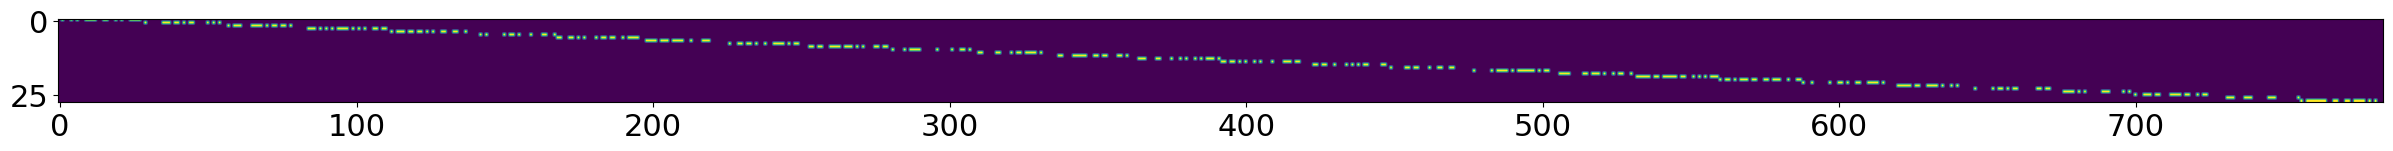

In [ ]:
plt.imshow(H3)

# Neural Estimation

## Image database

In [5]:
# load the mnist dataset of characters


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
x_trainN = np.reshape(x_train, (len(x_train), N, N, 1))
x_testN = np.reshape(x_test, (len(x_test), N, N, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


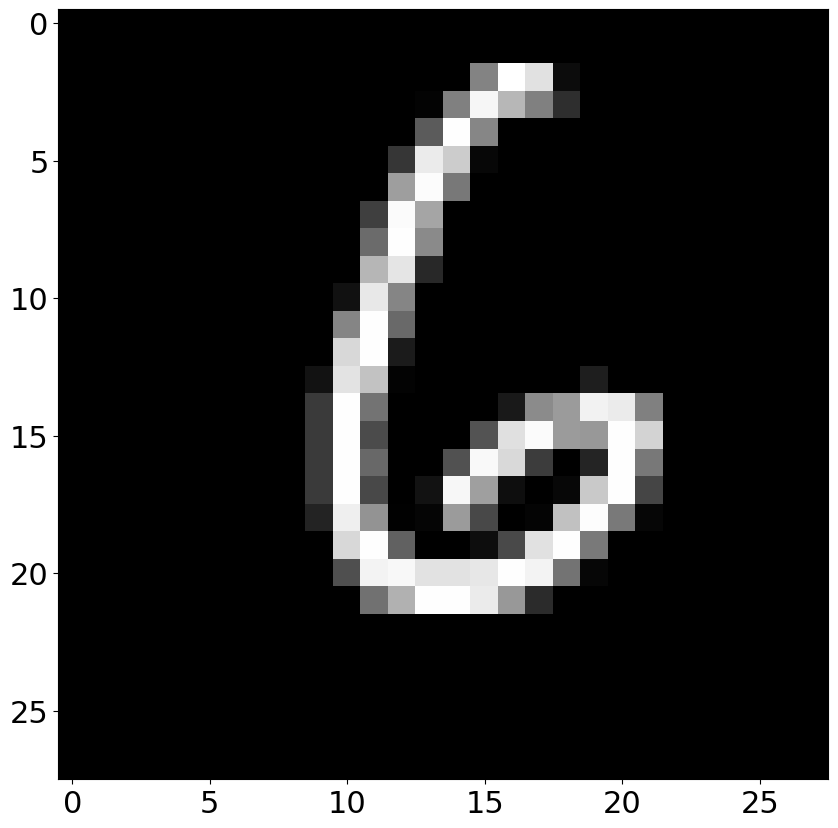

In [ ]:
plt.imshow(x_train[32],cmap='gray')

## Random illumination codes

###  prepare training data

In [6]:


g_test=np.zeros((x_test.shape[0],N))
g_train=np.zeros((x_train.shape[0],N))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:]= np.matmul(H3,np.reshape(x_test[pop],N**2))
  g_test[pop,:]=g_test[pop,:]/np.max(g_test[pop,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:]=np.matmul(H3,np.reshape(x_train[pop],N**2))
  g_train[pop,:]=g_train[pop,:]/np.max(g_train[pop,:])
g_train = np.reshape(g_train, (len(g_train), N))
g_test = np.reshape(g_test, (len(g_test), N))

### Encoder/denoising model

In [7]:
inputs=keras.Input(shape=([N]))
# Transformer
x =layers.Dense(N**2,activation="gelu")(inputs)
x = layers.Reshape((N,N,-1))(x)

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2D(32, (4, 4), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="gelu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

randomCodes = keras.Model(inputs, x)
randomCodes.compile(optimizer='adam', loss='mean_squared_error')
randomCodes.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 784)                 │          22,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 1)           │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,729 (467.69 KB)

 Trainable params: 119,729 (467.69 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [8]:
randomCodes.fit(
    x=g_train,
    y=x_trainN,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_testN),
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0653 - val_loss: 0.0387
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0378 - val_loss: 0.0340
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0334 - val_loss: 0.0304
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0303 - val_loss: 0.0281
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0285 - val_loss: 0.0273
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0273 - val_loss: 0.0268
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0264 - val_loss: 0.0258
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0255 - val_loss: 0.0251
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0251 - val_loss: 0.0246
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0246 - val_loss: 0.0244
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0241 - val_loss: 0.0241
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/st

### Example estimated images



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


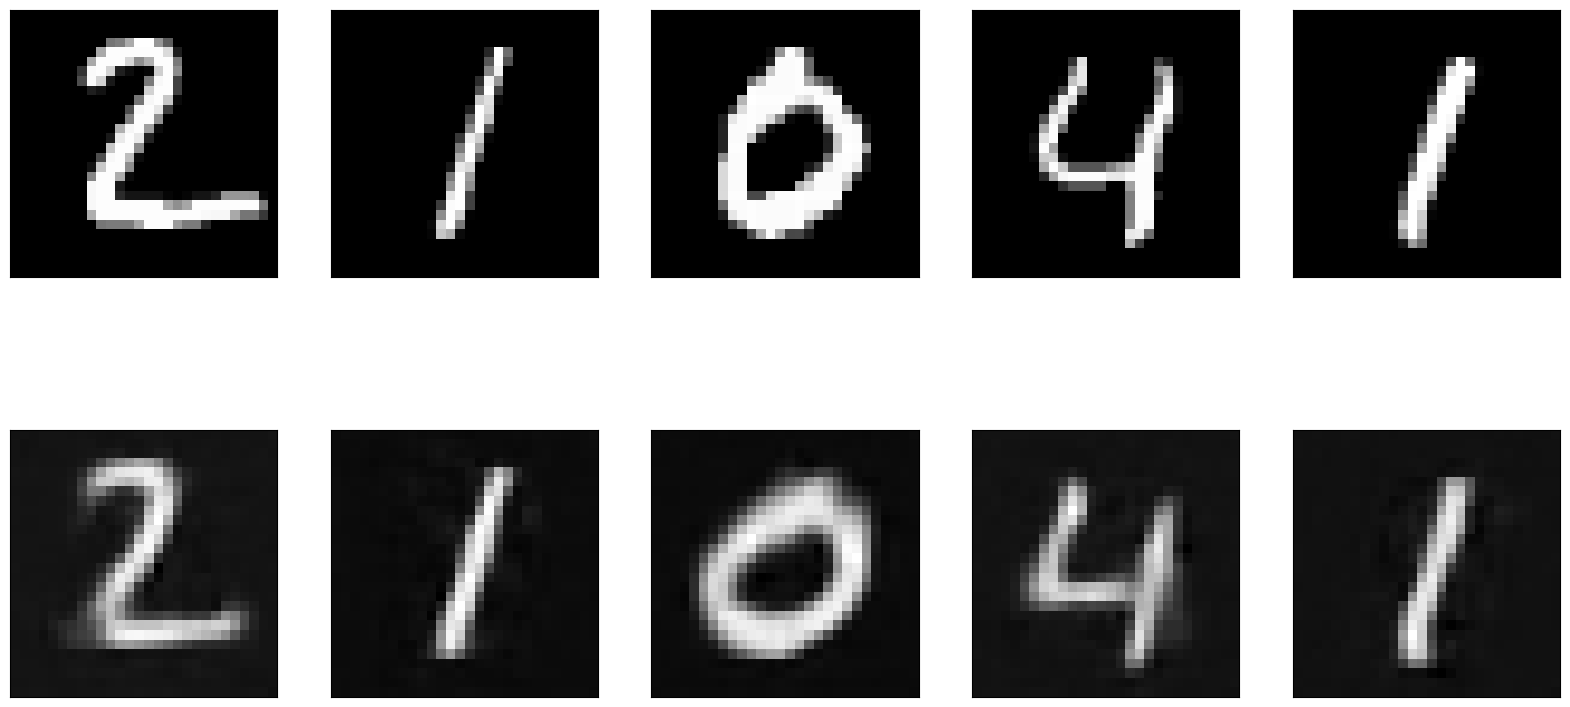

In [9]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(randomCodes.predict(g_test[i:(i+1),:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


## CACTI illumination codes

###  prepare training data

In [10]:
g_test=np.zeros((x_test.shape[0],N))
g_train=np.zeros((x_train.shape[0],N))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:]= np.matmul(H2,np.reshape(x_test[pop],N**2))
  g_test[pop,:]=g_test[pop,:]/np.max(g_test[pop,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:]=np.matmul(H2,np.reshape(x_train[pop],N**2))
  g_train[pop,:]=g_train[pop,:]/np.max(g_train[pop,:])
g_train = np.reshape(g_train, (len(g_train), N))
g_test = np.reshape(g_test, (len(g_test), N))

### Encoder/denoising model

In [11]:
inputs=keras.Input(shape=([N]))




# Transformer
x =layers.Dense(N**2,activation="gelu")(inputs)
x = layers.Reshape((N,N,-1))(x)

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

cactiCodes = keras.Model(inputs, x)
cactiCodes.compile(optimizer='adam', loss='mean_squared_error')
cactiCodes.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │          22,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 28, 28, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 28, 28, 1)           │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,729 (467.69 KB)

 Trainable params: 119,729 (467.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
inputs.shape

TensorShape([None, 28, 1])

### Training

In [12]:
cactiCodes.fit(
    x=g_train,
    y=x_trainN,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_testN),
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0634 - val_loss: 0.0389
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0377 - val_loss: 0.0341
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0338 - val_loss: 0.0322
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0319 - val_loss: 0.0307
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0307 - val_loss: 0.0300
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0298 - val_loss: 0.0291
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0291 - val_loss: 0.0289
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0285 - val_loss: 0.0292
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0282 - val_loss: 0.0278
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0275 - val_loss: 0.0280
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0271 - val_loss: 0.0272
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/st

### Example estimated images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


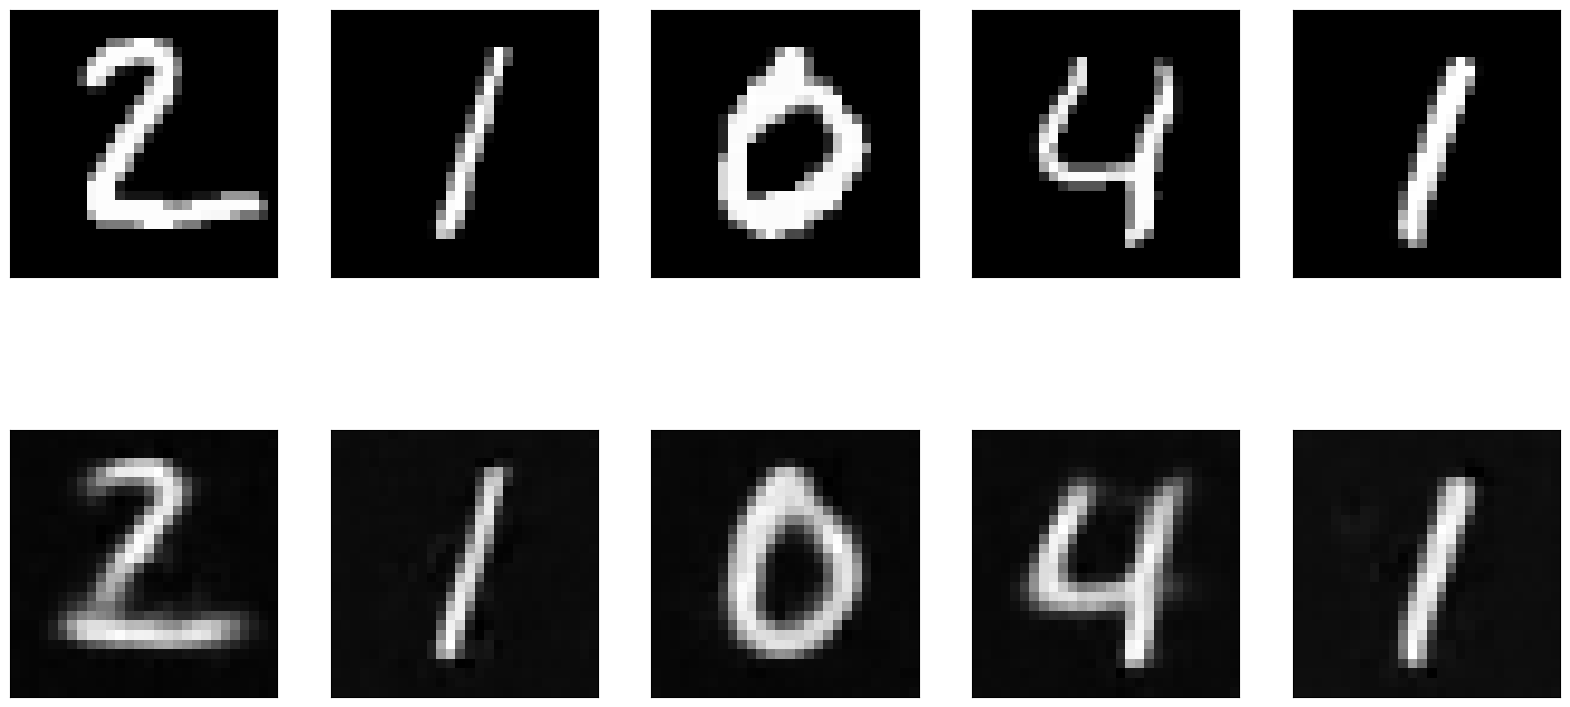

In [13]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(cactiCodes.predict(g_test[i:(i+1),:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



## Flutter illumination codes

###  prepare training data

In [14]:


g_test=np.zeros((x_test.shape[0],N))
g_train=np.zeros((x_train.shape[0],N))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:]= np.matmul(H1,np.reshape(x_test[pop],N**2))
  g_test[pop,:]=g_test[pop,:]/np.max(g_test[pop,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:]=np.matmul(H1,np.reshape(x_train[pop],N**2))
  g_train[pop,:]=g_train[pop,:]/np.max(g_train[pop,:])
g_train = np.reshape(g_train, (len(g_train), N))
g_test = np.reshape(g_test, (len(g_test), N))

### Encoder/denoising model

In [15]:
inputs=keras.Input(shape=([N]))




# Transformer
x =layers.Dense(N**2,activation="gelu")(inputs)
x = layers.Reshape((N,N,-1))(x)

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

flutterCodes = keras.Model(inputs, x)
flutterCodes.compile(optimizer='adam', loss='mean_squared_error')
flutterCodes.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │          22,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 28, 28, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 28, 28, 8)           │           1,160 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 28, 28, 1)           │              73 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,729 (467.69 KB)

 Trainable params: 119,729 (467.69 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
flutterCodes.fit(
    x=g_train,
    y=x_trainN,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_testN),
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0712 - val_loss: 0.0548
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0543 - val_loss: 0.0529
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0528 - val_loss: 0.0521
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0522 - val_loss: 0.0518
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0515 - val_loss: 0.0511
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0511 - val_loss: 0.0506
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0507 - val_loss: 0.0505
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0504 - val_loss: 0.0502
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0501 - val_loss: 0.0501
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0501 - val_loss: 0.0499
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0499 - val_loss: 0.0497
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


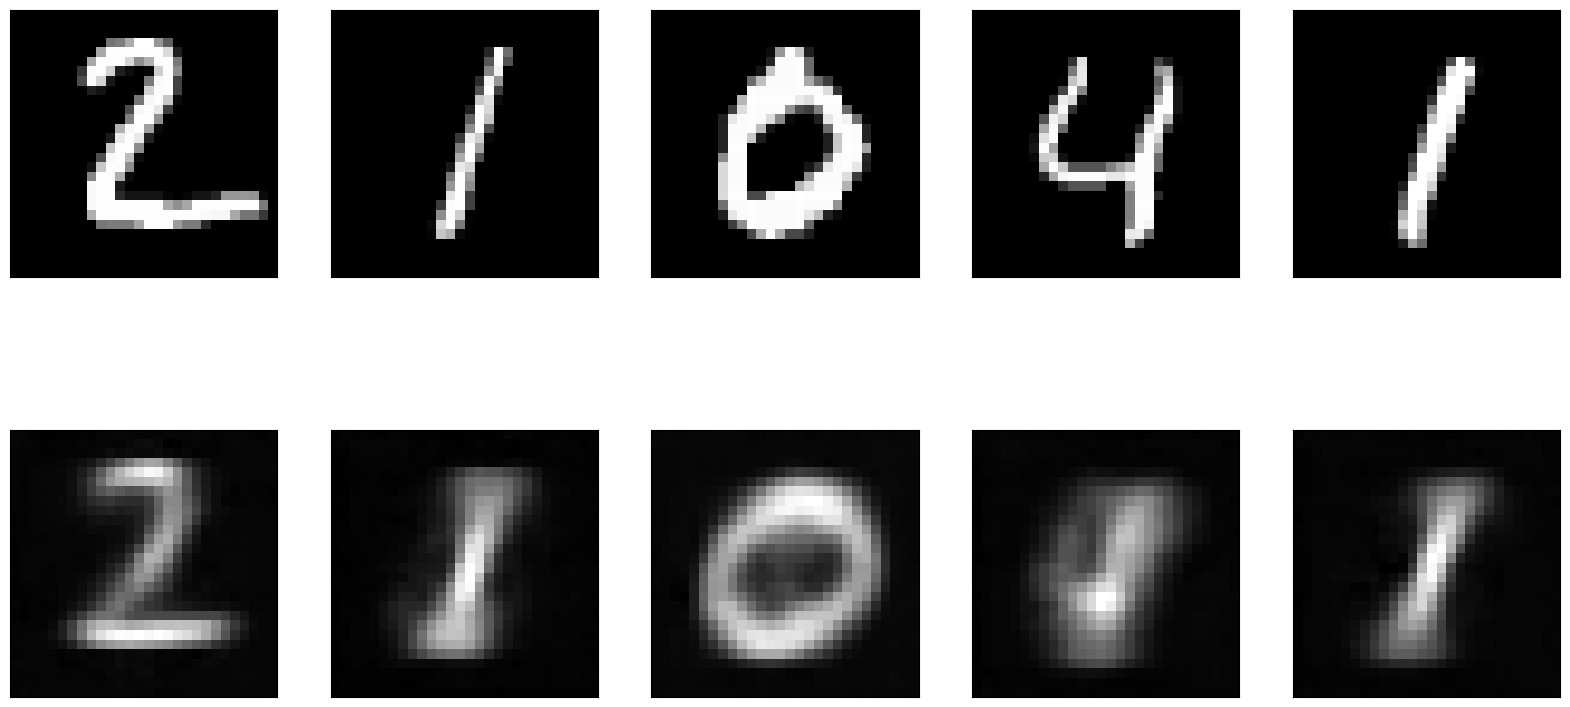

In [17]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(flutterCodes.predict(g_test[i:(i+1),:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

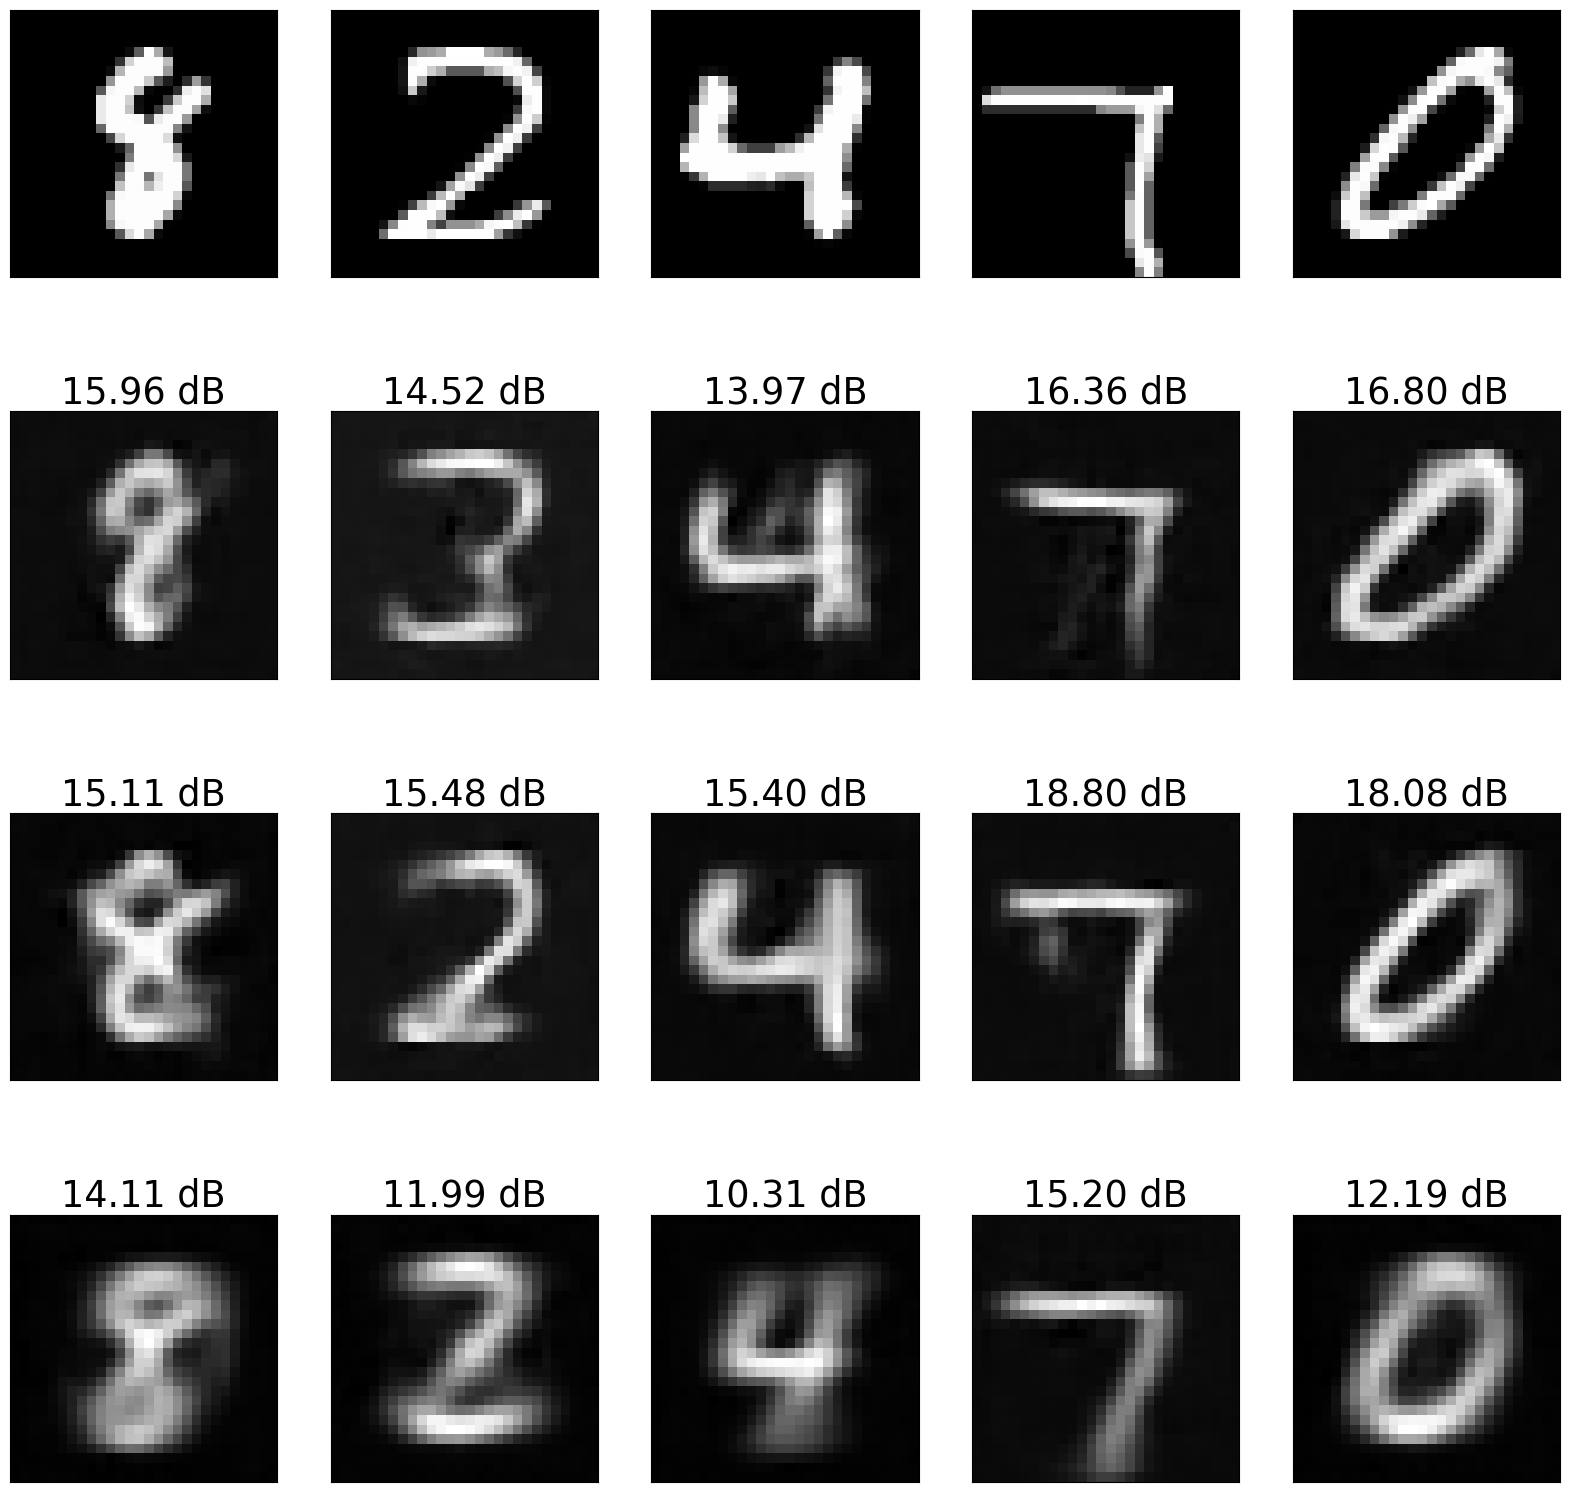

In [18]:
n = 5
plt.figure(figsize=(20, 20))
images=np.random.randint(1,1000,n+1)
#images=range(1,n+2)
for i in range(1, n +1):
    ax = plt.subplot(4, n, i)
    testImage=x_test[images[i]]
    plt.imshow(testImage)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, n+i)
    gt=np.reshape(np.matmul(H3,np.reshape(testImage,N**2)),(1,N))
    gt=gt/np.max(gt)
    plt.imshow(randomCodes.predict(gt)[0,:,:,0])
    plt.gray()
    plt.title('%.2f dB' %psnr(testImage,randomCodes.predict(gt)[0,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, 2*n+i)
    gt=np.reshape(np.matmul(H2,np.reshape(testImage,N**2)),(1,N))
    gt=gt/np.max(gt)
    plt.imshow(cactiCodes.predict(gt)[0,:,:,0])
    plt.gray()
    plt.title('%.2f dB' %psnr(testImage,cactiCodes.predict(gt)[0,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, 3*n+i)
    gt=np.reshape(np.matmul(H1,np.reshape(testImage,N**2)),(1,N))
    gt=gt/np.max(gt)
    plt.imshow(flutterCodes.predict(gt)[0,:,:,0])
    plt.gray()
    plt.title('%.2f dB' %psnr(testImage,flutterCodes.predict(gt)[0,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('cactiRecon.pdf')

In [ ]:
poop=np.reshape(gt,(1,N))